## Micrograd scratchpad

Notes from Karpathy's micrograd walkthrough. Flow: build `Value` for scalar autograd -> visualize the graph -> manual vs automated backprop -> tiny MLP trained with GD.

https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

### Autograd scaffold
Minimal `Value` class for scalars with operator overloads, tanh/exp helpers, `backward`, and a toy chain to trace.

In [100]:
class Value:

    def __init__(self,data, _children = (), _op='',label=""):
        self.data=data
        self.grad = 0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other) # lets you add constants
        out = Value(self.data + other.data, (self,other), '+')
        def _backward():
            self.grad +=1.0*out.grad
            other.grad +=1.0*out.grad
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    # ensures we can do 2 * Value
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        # derivative of x^n is n*x^(n-1) therefore we multiply with other * (self.data ** (other -1)) and out.grad which is the gradient from above, so local gradient times chain rule
        # where other is n and self.data is x
        def _backward():
            self.grad += other * (self.data ** (other -1)) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        # derivative of e^x is e^x, therefore we multiply with out.data which is e^x and out.grad which is the gradient from above, so local gradient times chain rule
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label="e"
d=e+c; d.label="d"
f = Value(-2.0, label="f")
L = d* f; L.label="L"
d._op

'+'

In [50]:
from graphviz import Digraph

def trace(root):
    nodes,edges = set(),set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr=({'rankdir':'LR'}))

    nodes,edges = trace(root)

    for n in nodes:
        uid=str(id(n))

        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad, ), shape="record")

        if n._op:
            dot.node(name=uid+n._op,label=n._op)

            dot.edge(uid+n._op,uid)

    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    

    return dot

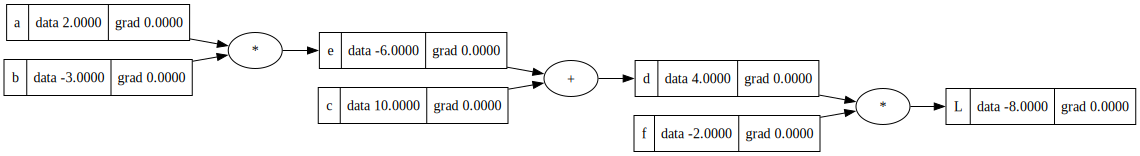

In [51]:
draw_dot(L)

### Tanh toy example
Scalar neuron with two inputs to visualize the graph before doing any backward passes.

In [57]:

# inputs x1,x2
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

# weights  w1,w2
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh()


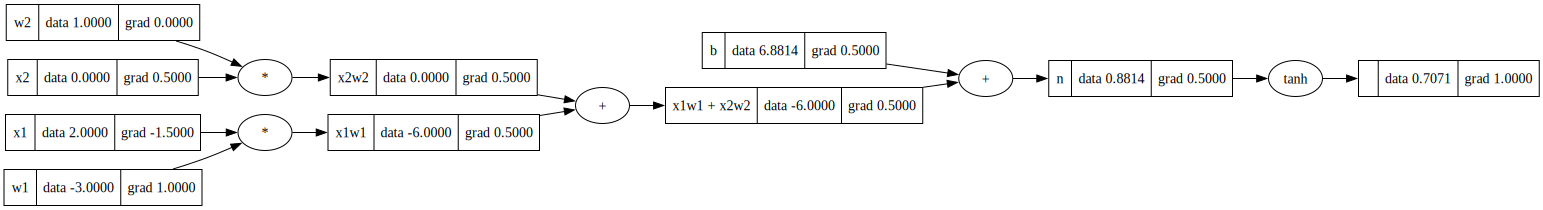

In [65]:
draw_dot(o)


### Manual backward check
Hand-compute gradients for the tanh neuron to sanity check signs and scales before trusting the autograd.

In [64]:
#manually backpropagation
o.grad = 1.0

# o = tanh(n)
# do/dn = 1- tanh(n)**2 = 1-o**2 

n.grad =1-o.data**2

b.grad = n.grad * 1.0
x1w1x2w2.grad = n.grad * 1.0

x2w2.grad = x1w1x2w2.grad * 1.0
x1w1.grad = x1w1x2w2.grad * 1.0

w1.grad = x1w1.grad * x1.data # dL/dw1 = dL/dx1w1 * dx1w1/dw1 hvor dx1w1/dw1 = x1.data
x1.grad = x1w1.grad * w1.data # motsatt som over, bare w1 data istedenfor x1 data

w2.grad = x2w2.grad * x2.data
x2.grad = x2w2.grad * w2.data


### Stepping toward autograd
Call each `_backward` manually, then switch to `backward()` to confirm the graph wiring and gradient accumulation.

In [73]:
# Semi-Automated backpropagation
# inputs x1,x2
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

# weights  w1,w2
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh()


In [81]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
w1._backward()
x1._backward()
w2._backward()
x2._backward()


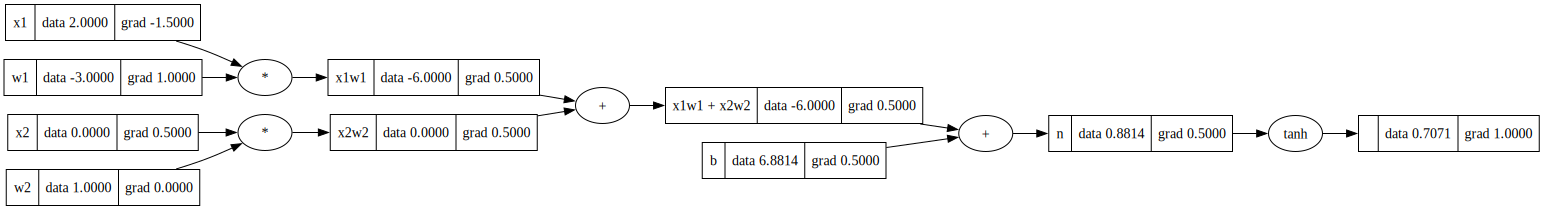

In [82]:
draw_dot(o)


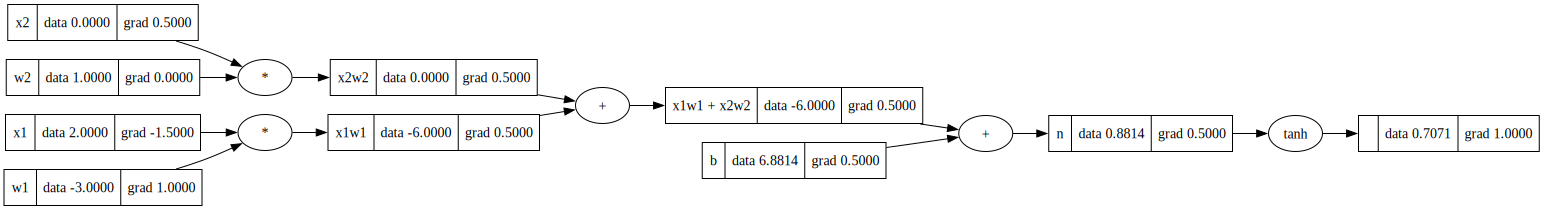

In [87]:
# Semi-Automated backpropagation
# inputs x1,x2
x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

# weights  w1,w2
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"
o = n.tanh()

o.backward()

draw_dot(o)

### Gradient accumulation
`backward()` relies on each `_backward` using `+=` so shared nodes accumulate gradients; next cell shows the fix and verifies with a tiny graph.

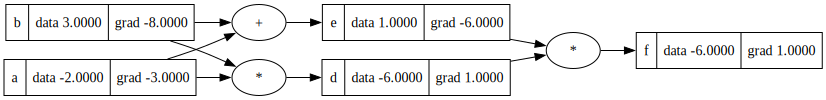

In [91]:
# Bug, fix is in _backward methods to use += instead of =, so we accumulate gradients properly 
a=Value(-2.0, label="a")
b=Value(3.0, label="b")
d=a*b ; d.label="d"
e = a+b ; e.label="e"
f = d * e ; f.label="f"
f.backward()
draw_dot(f)

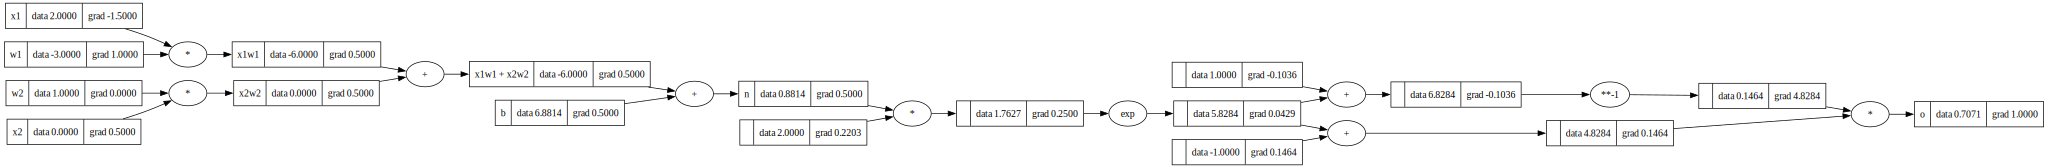

In [101]:
# Automated backprop without the tanh function but manually created
# inputs x1,x2


x1 = Value(2.0,label="x1")
x2 = Value(0.0,label="x2")

# weights  w1,w2
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")
b = Value(6.8813735870195432,label="b")

# x1w1 + x2w2 + b
x1w1 = x1 * w1; x1w1.label="x1w1"
x2w2 = x2 * w2; x2w2.label="x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1w1 + x2w2"
n = x1w1x2w2 + b; n.label="n"


e = (2*n).exp()
o = (e-1)/(e+1)
o.label="o"
o.backward()

draw_dot(o)

### Tiny MLP
`Neuron`, `Layer`, and `MLP` reuse `Value` ops; activations are tanh and weights are small random scalars.

In [310]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0.0)
    
    def __call__(self, x):
        # weighted sum
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        # activation function
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs if len(outs)>1 else outs[0]
    
    def parameters(self):
        params = []
        for n in self.neurons:
            params.extend(n.parameters())
        return params

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
    

x = [2.0,3.0,-1.0]
#3 inputs, 4 hidden neurons, 4 hidden neurons, 1 output neuron 
n = MLP(3,[4,4,1]) 
n(x)


Value(data=0.6620484409674366)

In [308]:
xs =[
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0],
]

ys = [1.0,-1.0,-1.0,1.0] #targets

ypred = [n(x) for x in xs]
print(ypred)

[Value(data=0.37726818437955184), Value(data=0.2823659921298952), Value(data=-0.5767296444063562), Value(data=0.5959213977502201)]


### Simple training loop
Four toy examples, mean-squared loss, zero grads, backward, and SGD step at a fixed learning rate.

In [ ]:
for i in range(30):

    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ytarget)**2 for yout, ytarget in zip(ypred, ys)), Value(0.0))
    #zero gradients
    for p in n.parameters():
        p.grad =0.0
    #backward pass, take derivative of loss which is the final output value object and call backward on it
    loss.backward()
    #update weights
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(f"epoch {i} loss {loss.data}")

#check a weight
n.layers[0].neurons[0].w[0].data

n.layers[0].neurons[0].w[0].grad


#y pred
ypred = [n(x) for x in xs]
print(ypred)

epoch 0 loss 4.996086638428568
epoch 1 loss 2.5793010352617998
epoch 2 loss 4.426982394512937
epoch 3 loss 1.2122591298484615
epoch 4 loss 0.05415611710569395
epoch 5 loss 0.04198526792292698
epoch 6 loss 0.03488823412746396
epoch 7 loss 0.030120983511905428
epoch 8 loss 0.026644439606234523
epoch 9 loss 0.023968919888476957
epoch 10 loss 0.021830309502558858
epoch 11 loss 0.02007222892617231
epoch 12 loss 0.01859548749129753
epoch 13 loss 0.01733373946491374
epoch 14 loss 0.016240695816474405
epoch 15 loss 0.015282933393735664
epoch 16 loss 0.014435623043647757
epoch 17 loss 0.013679873797429765
epoch 18 loss 0.0130010173594259
epoch 19 loss 0.012387463173944475
epoch 20 loss 0.011829912414909584
epoch 21 loss 0.011320804922933048
epoch 22 loss 0.010853921526589013
epoch 23 loss 0.010424092548798548
epoch 24 loss 0.010026980456371775
epoch 25 loss 0.00965891528730106
epoch 26 loss 0.009316768304834005
epoch 27 loss 0.008997853777174799
epoch 28 loss 0.008699851748059383
epoch 29 loss 